In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/eas_508_project/notebooks
Current working directory: /shared_folder/eas_508_project


In [2]:
pbp_path = 'data/raw/pbp_data/'

pbp_name = 'pbp_2016.csv'

fb_df = pd.read_csv(pbp_path + pbp_name)
shape = fb_df.shape
columns = fb_df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

fb_df.head()

/tmp/ipykernel_53510/3081738536.py:5: DtypeWarning: Columns (196,197,199,200,206,207,210,211,214,215,220,221,222,223,226,227,235,236,237,265,266,270,271,272,277,279,280,300,301) have mixed types. Specify dtype option on import or set low_memory=False.
  fb_df = pd.read_csv(pbp_path + pbp_name)


✔✔✔ File Loaded

Shape: (47651, 389)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type', 'defense_coverage_type', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_poin

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,2016_01_BUF_BAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016_01_BUF_BAL,36,BUF,NaN,NaN,NaN,NaN,NaN,40078;40151;37977;36060;40494;40053;40253;4011...,00-0030041;00-0030073;00-0029799;00-0030433;00...,...,0,1,-0.955114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016_01_BUF_BAL,58,BAL,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",NaN,38540;41302;40078;35553;38582;43295;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,1,1,0.336466,NaN,NaN,NaN,NaN,NaN,0.460759,-46.075901
3,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",3.0,41302;40078;38540;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,0.644540,1.567466,9.753489,8.0,0.63767,0.530295,0.426425,57.357508
4,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",NaN,40078;38540;41302;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,-0.546209,NaN,NaN,NaN,NaN,NaN,0.456597,-45.659652


#### Extracting useful columns from dataframe and grouping them by category

In [3]:
#Extracting Useful Columns
#play info
play_state = ['nflverse_game_id','play_id','posteam','posteam_type','defteam','yardline_100','game_seconds_remaining','down','goal_to_go','ydstogo',
              'desc','posteam_score','defteam_score','score_differential','wp','ep']

#Formation for pre-snap
formation_info = ['offense_formation','offense_personnel','defenders_in_box','defense_personnel','n_offense','n_defense']

#outputs to test on
output_info = ['epa','wpa','success']

#Additional info for deep dives
side_info = ['home_timeouts_remaining','home_timeouts_remaining','timeout','timeout_team','posteam_score','defteam_score','roof','surface','temp','wind','total_line','spread_line']

#yardage in games, do not use for modeling to prevent leakage
in_play = ['rush_attempt','pass_attempt','passing_yards','receiving_yards','rushing_yards','lateral_receiving_yards','lateral_rushing_yards']

#remove kneel, spike == 1 and play_type not pass or run
to_remove = ['qb_kneel', 'qb_spike', 'play_type']

In [4]:
to_pull = play_state + formation_info + side_info + to_remove + in_play + output_info

df = fb_df[to_pull]

#### NaN plays are in DF, these represent no plays or special team plays or end of quarters/halfs. Making a function to remove such plays as well as kneels, spikes.

In [5]:
#Create Remove Plays func for clean_data func
def remove_plays(dataframe):
    df = dataframe.copy()

    formation = df['offense_formation'].notna()
    personnel = df['offense_personnel'].notna()
    no_play = df['play_type'] != 'no_play'
    kneel = df['qb_kneel'] == 0
    spike = df['qb_spike'] == 0

    df = df[formation & personnel & no_play & kneel & spike].drop(columns=['qb_kneel','qb_spike'])

    return df

In [6]:
df = remove_plays(df)

#Check Data

In [7]:
df['play_type'].value_counts()

play_type
pass    20115
run     13344
Name: count, dtype: int64

In [8]:
#Look at formation_info set
df[formation_info].head()

,offense_formation,offense_personnel,defenders_in_box,defense_personnel,n_offense,n_defense
2,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11
3,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",11,11
4,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11
5,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",11,11
6,I_FORM,"1 RB, 2 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",11,11


In [9]:
#Check for low offense and defense counts:
print(df['n_offense'].value_counts(), df['n_defense'].value_counts())

n_offense
11    31318
10     2127
9        13
0         1
Name: count, dtype: int64 n_defense
11    31278
10     2093
9        74
8        13
0         1
Name: count, dtype: int64


In [10]:
#Need to remove values less than 11 as this is random noise and will mess with personnel data
df = df[(df['n_offense'] == 11) & (df['n_defense'] == 11)].drop(columns=['n_offense','n_defense'])

In [11]:
#We have personnel counts 
df['offense_personnel'].value_counts()

offense_personnel
1 RB, 1 TE, 3 WR                17007
1 RB, 2 TE, 2 WR                 5115
2 RB, 1 TE, 2 WR                 2145
1 RB, 3 TE, 1 WR                  862
1 RB, 0 TE, 4 WR                  724
2 RB, 2 TE, 1 WR                  558
6 OL, 1 RB, 1 TE, 2 WR            512
6 OL, 1 RB, 2 TE, 1 WR            441
0 RB, 1 TE, 4 WR                  408
2 RB, 0 TE, 3 WR                  394
6 OL, 2 RB, 1 TE, 1 WR            253
6 OL, 2 RB, 2 TE, 0 WR            208
6 OL, 1 RB, 0 TE, 3 WR            133
0 RB, 2 TE, 3 WR                  113
6 OL, 2 RB, 0 TE, 2 WR             59
0 RB, 0 TE, 5 WR                   58
6 OL, 1 RB, 3 TE, 0 WR             41
0 RB, 3 TE, 2 WR                   30
2 RB, 3 TE, 0 WR                   25
3 RB, 1 TE, 1 WR                   25
2 QB, 1 RB, 1 TE, 2 WR             16
7 OL, 1 RB, 1 TE, 1 WR             11
1 RB, 1 TE, 4 WR                   11
6 OL, 1 RB, 2 TE, 0 WR,1 DL        10
7 OL, 1 RB, 2 TE, 0 WR              9
3 RB, 0 TE, 2 WR                

In [12]:
#Convert Offense Personnel to Dictionary Storage for easy recall
df['personnel_dict'] = df['offense_personnel'].apply(lambda x: {pos: int(count) for count, pos in (p.strip().split(' ') for p in x.split(','))})

df['QB'] = 1
df['OL'] = 5

personnel_titles = ['RB','TE','WR','OTHER']

for pos in personnel_titles:
    df[f'{pos}'] = 0

def update_personnel_counts(row):
    for k,v in row['personnel_dict'].items():
        if k in personnel_titles:
            row[k] += v
        else:
            if k == 'QB':
                row[k] = v
            elif k == 'OL':
                row[k] = v
            else:
                row['OTHER'] += v
    return row

df = df.apply(update_personnel_counts, axis=1)

df['success'] = df['success'].astype(int)

In [33]:
df.columns

Index(['nflverse_game_id', 'play_id', 'posteam', 'posteam_type', 'defteam',
       'yardline_100', 'game_seconds_remaining', 'down', 'goal_to_go',
       'ydstogo', 'desc', 'posteam_score', 'defteam_score',
       'score_differential', 'wp', 'ep', 'offense_formation',
       'offense_personnel', 'defenders_in_box', 'defense_personnel',
       'home_timeouts_remaining', 'home_timeouts_remaining', 'timeout',
       'timeout_team', 'posteam_score', 'defteam_score', 'roof', 'surface',
       'temp', 'wind', 'total_line', 'spread_line', 'play_type',
       'rush_attempt', 'pass_attempt', 'passing_yards', 'receiving_yards',
       'rushing_yards', 'lateral_receiving_yards', 'lateral_rushing_yards',
       'epa', 'wpa', 'success', 'personnel_dict', 'QB', 'OL', 'RB', 'TE', 'WR',
       'OTHER'],
      dtype='object')

In [34]:
quan_df = ['yardline_100','game_seconds_remaining','ydstogo','wp','ep','temp','wind','total_line','spread_line']
qual_df = ['down','goal_to_go','score_differential','wp','ep','offense_personnel','QB','OL','RB','TE','WR','OTHER','offense_formation']

<Figure size 640x480 with 0 Axes>

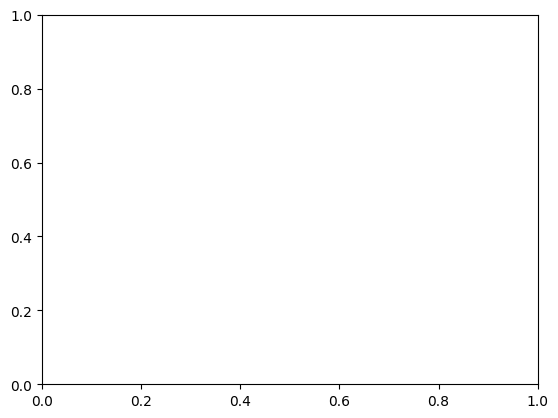

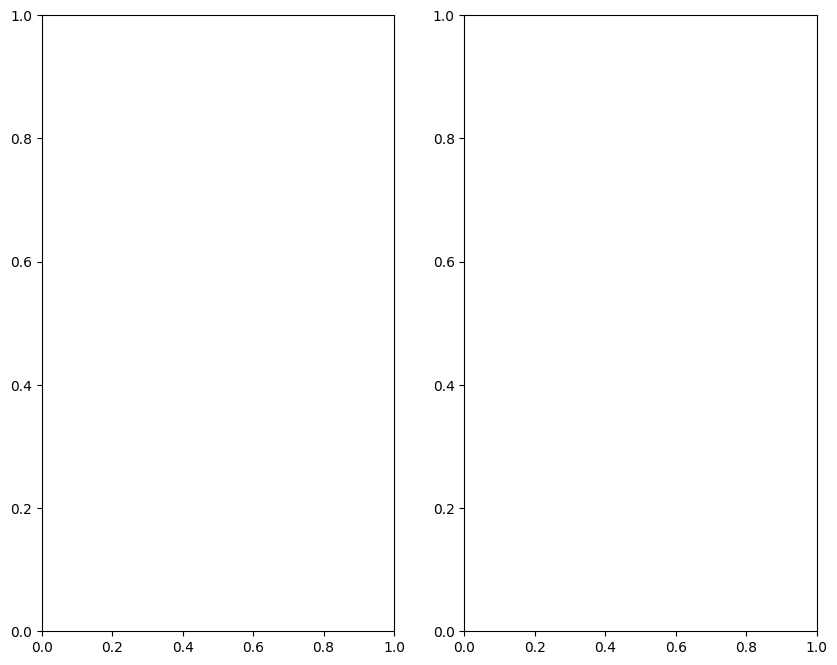

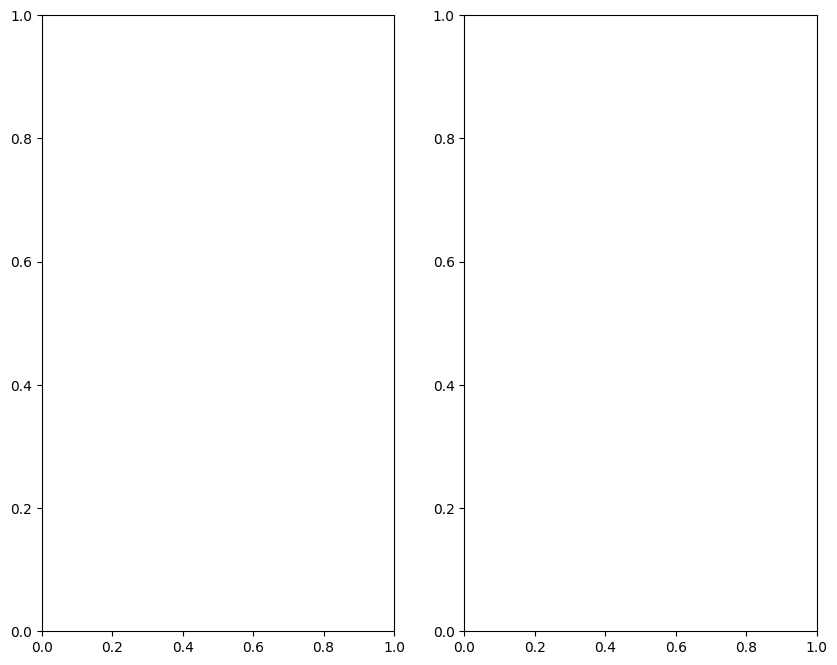

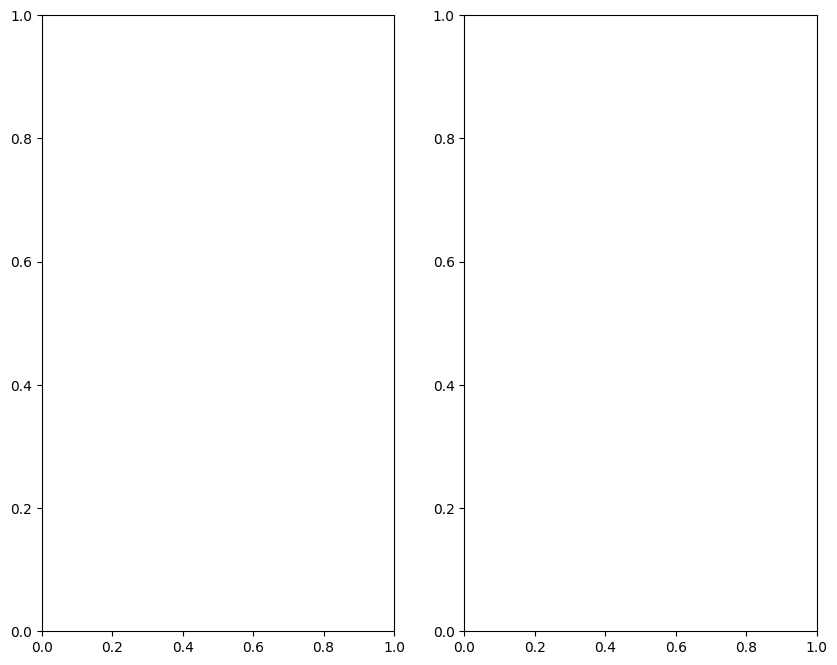

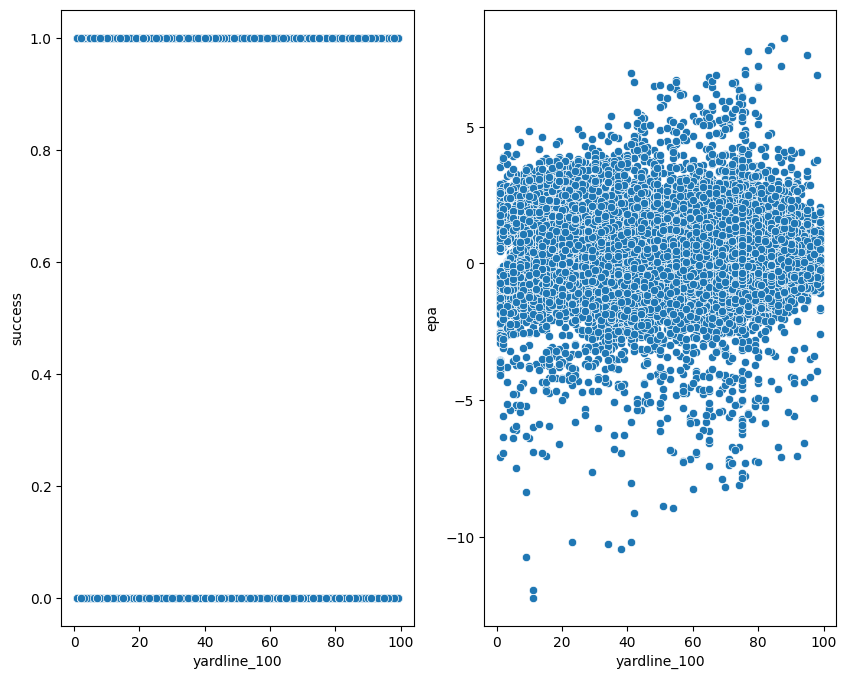

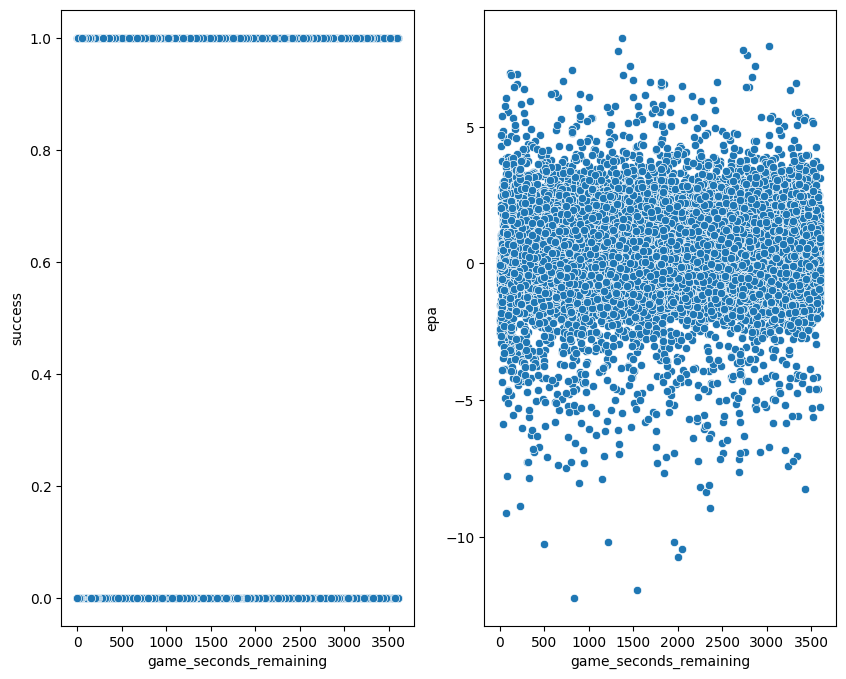

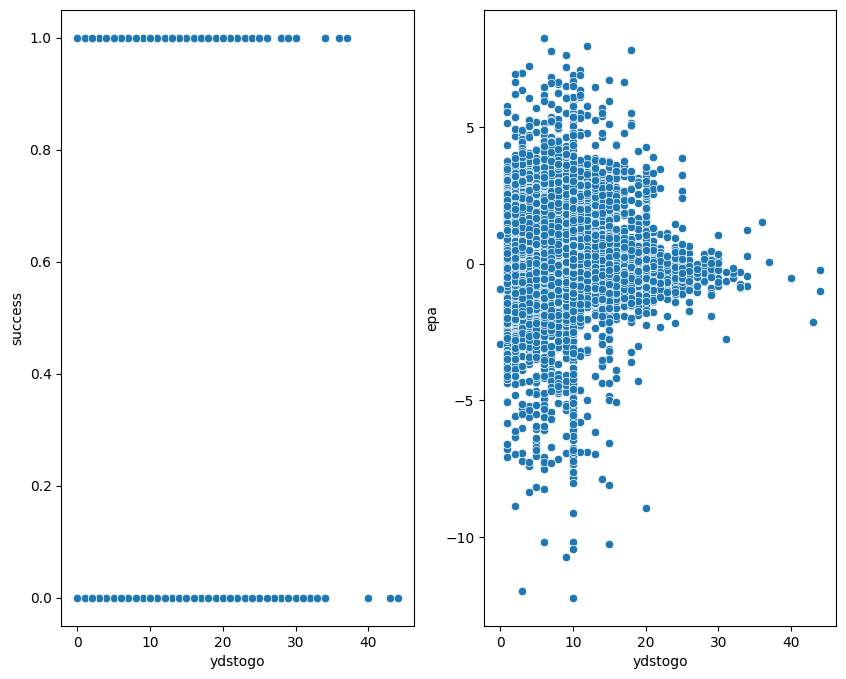

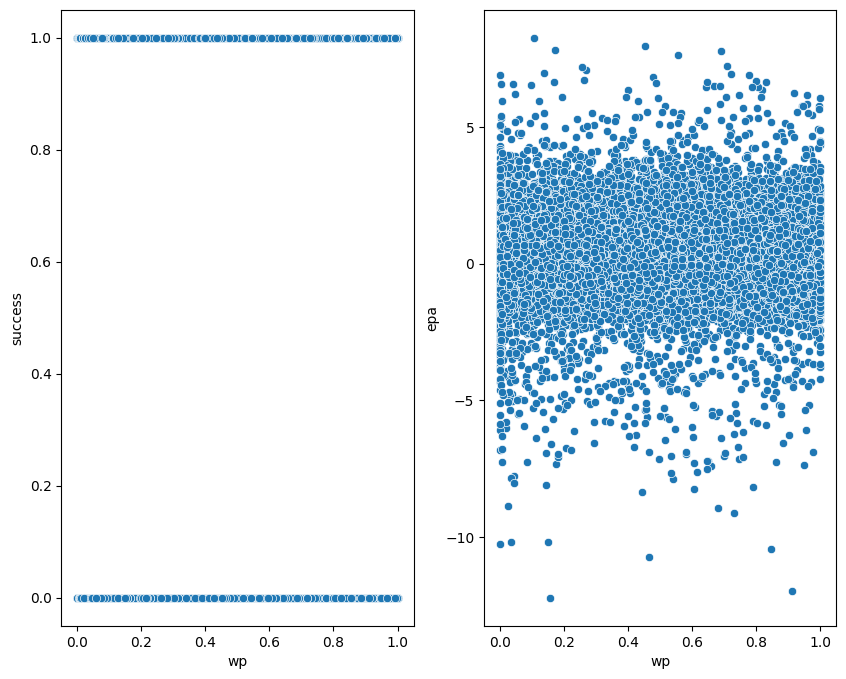

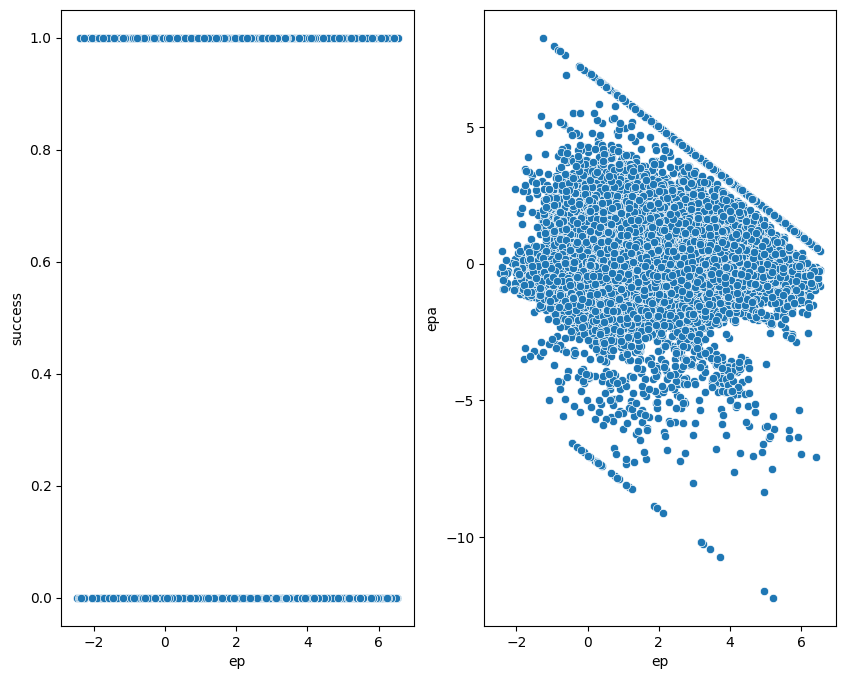

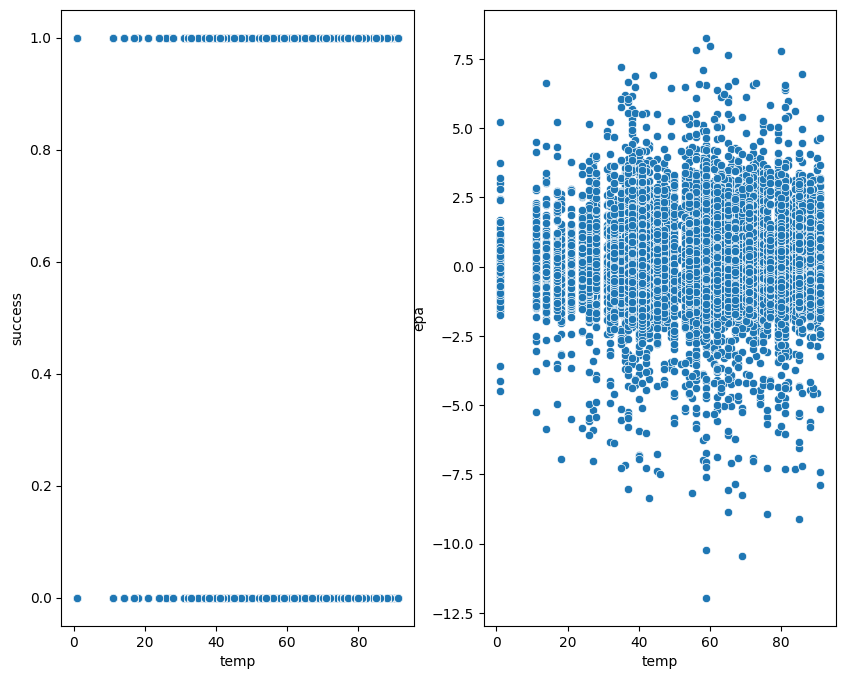

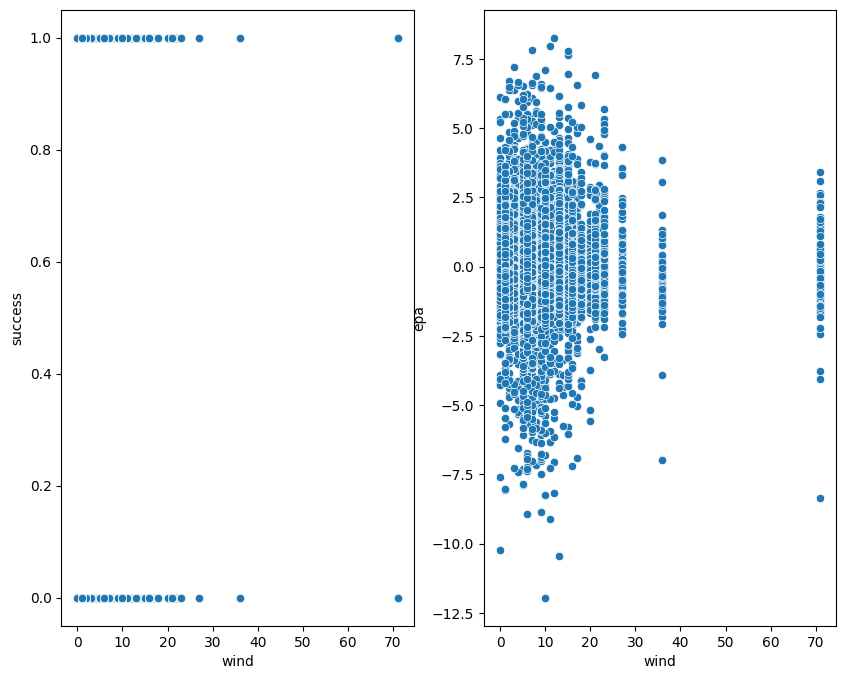

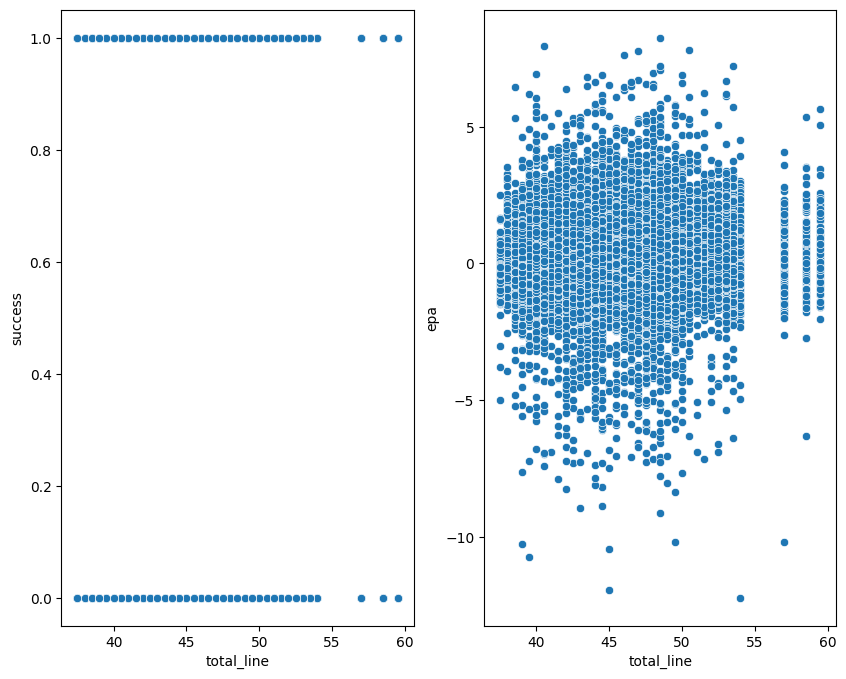

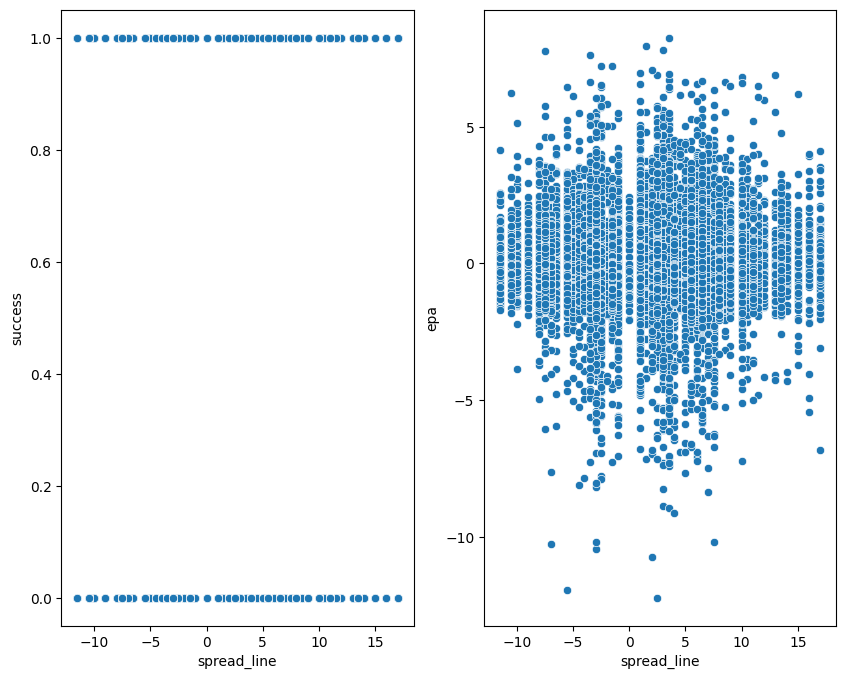

In [42]:
for item in df[quan_df].columns:
    fig, axes = plt.subplots(1,2,figsize=(10,8))
    sns.scatterplot(x=item,y='success',data=df,ax=axes[0])
    sns.scatterplot(x=item,y='epa',data=df,ax=axes[1])
    plt.show()